In [64]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

%matplotlib inline

In [65]:
## Data does not have column headers, so we set these up to add custom column names
column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking as it is a large file
df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

In [66]:
## As we are interested in only selected columns, restructure the data for these columns
## exclude transaction ID, secondary address (SAON), PPD category type, and record status
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

In [67]:
## We will create a couple new columns, which will help in our later analysis.
## These will be a trimmed postcode that correlates to postcode areas, as well as 
## month and year separated out from date column.

## Trim the postcode column down to the first set of characters (removing last 3)
df['postcode_area'] = [str(x)[:-4] for x in df.postcode]

## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

In [70]:
## We inspect the new dataframe
df.head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year
0,770000,2018-09-25,SK7 1AR,D,N,F,5,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,SK7,9,2018
1,253500,2018-09-24,M6 8GQ,D,N,F,1,RIVINGTON ROAD,NaN,SALFORD,SALFORD,GREATER MANCHESTER,M6,9,2018
2,231950,2018-09-28,WA3 2UE,D,Y,F,35,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,WA3,9,2018
3,112500,2018-08-29,OL6 6RJ,S,N,F,102,THORNFIELD GROVE,NaN,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,OL6,8,2018
4,184995,2018-06-15,M46 0TW,S,Y,F,37,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,M46,6,2018


In [71]:
## We will add more details to the dataset to make it more understandable for readers

prop_type_dict = {'D': 'Detached',
                 'S': 'Semi-detached',
                 'F': 'Flat',
                 'T': 'Terraced',
                 'O': 'Other'}

new_build_dict = {'N': 'Old',
                 'Y': 'New'}

duration_dict = {'F': 'Freehold',
                 'L': 'Leasehold'}

In [76]:
## Then apply the function to convert the existing values into more readable values
## comment out to prevent future errors // 
## df['property_type'] = df['property_type'].map(prop_type_dict)

In [77]:
## comment out to prevent future errors // 
## df['new_build'] = df['new_build'].map(new_build_dict)

In [78]:
## comment out to prevent future errors // 
## df['duration'] = df['duration'].map(duration_dict)

In [75]:
df.head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year
0,770000,2018-09-25,SK7 1AR,Detached,Old,Freehold,5,OAK MEADOW,BRAMHALL,STOCKPORT,STOCKPORT,GREATER MANCHESTER,SK7,9,2018
1,253500,2018-09-24,M6 8GQ,Detached,Old,Freehold,1,RIVINGTON ROAD,NaN,SALFORD,SALFORD,GREATER MANCHESTER,M6,9,2018
2,231950,2018-09-28,WA3 2UE,Detached,New,Freehold,35,STONEACRE CLOSE,LOWTON,WARRINGTON,WIGAN,GREATER MANCHESTER,WA3,9,2018
3,112500,2018-08-29,OL6 6RJ,Semi-detached,Old,Freehold,102,THORNFIELD GROVE,NaN,ASHTON-UNDER-LYNE,TAMESIDE,GREATER MANCHESTER,OL6,8,2018
4,184995,2018-06-15,M46 0TW,Semi-detached,New,Freehold,37,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,M46,6,2018


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023150 entries, 0 to 1023149
Data columns (total 15 columns):
price            1023150 non-null int64
transfer_date    1023150 non-null datetime64[ns]
postcode         1017226 non-null object
property_type    1023150 non-null object
new_build        1023150 non-null object
duration         1023150 non-null object
PAON             1023150 non-null object
street           1003520 non-null object
locality         385531 non-null object
town_city        1023150 non-null object
district         1023150 non-null object
county           1023150 non-null object
postcode_area    1023150 non-null object
month            1023150 non-null int64
year             1023150 non-null int64
dtypes: datetime64[ns](1), int64(3), object(11)
memory usage: 117.1+ MB


### Summary of key statistics

In [107]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)
year_select = 2018
sales_count = len(df.year == year_select)

## Key summary statistics and print out
print("Total number of homes sold in " + str(year_select) + ": " + format(sales_count, ","))
print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

Total number of homes sold in 2018: 1,023,150
Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000


In [121]:
## Count and sort the number of properties sold by city to create a top 10 list

from collections import Counter

def top_cities(start_range, end_range):
    cities_list = df.town_city

    cities_count = Counter(cities_list)
    cities_ranked = pd.DataFrame.from_dict(cities_count, orient='index').reset_index()
    cities_ranked.columns = ['City', 'Count of Sales']
    cities_ranked = cities_ranked.sort_values('Count of Sales', ascending=False).reset_index(drop=True)

    cities_top = pd.DataFrame(cities_ranked[start_range-1:end_range])
    cities_top.index += 1
    print(cities_top)
    
top_cities(100, 300)

                   City  Count of Sales
100            HEREFORD            2076
101            DARTFORD            2063
102           BLACKBURN            2043
103      GREAT YARMOUTH            2038
104         KING'S LYNN            2035
..                  ...             ...
296            WALLSEND             832
297              KENDAL             832
298      MELTON MOWBRAY             830
299  SUTTON-IN-ASHFIELD             823
300               ALTON             823

[201 rows x 2 columns]


In [86]:
## To look for information on any given city we create a function to return some stats on 
## any selected city
def city_key_stats(city):
    avg_price_paid = round(df[df.town_city == city.upper()].price.mean(), 2)
    median_price_paid = round(df[df.town_city == city.upper()].price.median(), 2)
    print("Average 2018 price paid in " + city + " was: £" + format(avg_price_paid, ",.0f"))
    print("Average 2018 price paid in " + city + " was: £" + format(median_price_paid, ",.0f"))

city_key_stats('Brighton')

Average 2018 price paid in Brighton was: £477,545
Average 2018 price paid in Brighton was: £342,500


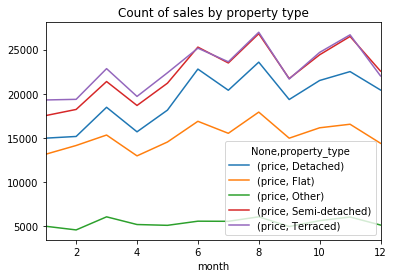

In [87]:
## Graphing homes sold over time during the year, by property type
count_by_month = df[['month','property_type','price']].groupby(['month', 'property_type']).count()
count_by_month = count_by_month.unstack().plot(kind='line', legend=True, 
                                               title='Count of sales by property type')

### Viewing the dataset by selecting criteria

In [106]:
## Explore the postcodes with price range and property type
def search(price_min, price_max, prop_type):
    priceFloor = df.price > price_min
    priceCeiling = df.price < price_max
    propertyType = df.property_type == prop_type
    query = df[priceFloor & priceCeiling & propertyType].reset_index()
    df_query = pd.DataFrame(query[['price','postcode','property_type','town_city']]).sort_values('price')
    print(df_query.head(100))
          
search(350000, 400000, 'Flat')

       price  postcode property_type     town_city
4556  350055   BS6 6XX          Flat       BRISTOL
5532  350100  SO23 7JG          Flat    WINCHESTER
2067  350100   E14 6TW          Flat        LONDON
4571  350100   GU1 3XL          Flat     GUILDFORD
6272  350100   E14 3NT          Flat        LONDON
...      ...       ...           ...           ...
809   351750   UB7 9FF          Flat  WEST DRAYTON
3579  351785  SG13 8FQ          Flat      HERTFORD
3580  351785  SG13 8FQ          Flat      HERTFORD
3573  351785  SG13 8FQ          Flat      HERTFORD
13    351800  SE25 6NW          Flat        LONDON

[100 rows x 4 columns]


### Compare multiple cities prices paid

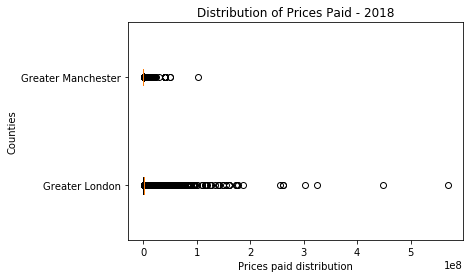

In [135]:
def county_comparison(county1, county2):
    county01 = df[df['county'] == county1.upper()]
    county02 = df[df['county'] == county2.upper()]
    
    if (len(county01) == 0) or (len(county02)) == 0:
        print('One or both of your selected counties is not available')
    
    else:    
        plt.boxplot([county01.price, county02.price], labels=[county1, county2], 
            autorange=True, widths=0.15, vert=False)
        plt.title('Distribution of Prices Paid - 2018')
        plt.xlabel('Prices paid distribution')
        plt.ylabel('Counties')
        plt.show()
    
county_comparison('Greater London', 'Greater Manchester')

In [145]:
## Add in the population density information to create a scatter plot of prices to density
## Data source: Nomis UK population database of all postcode areas and population density from
## 2011 - ONS Crown Copyright Reserved [from Nomis on 24 October 2019]
pop_density = pd.read_csv('UK_pop_density_postcodes.csv')[8:]
density_columns = ['long_code', 'postcode_area', 'population_density']
pop_density.columns = density_columns
pop_density = pop_density.drop(columns='long_code')
pop_density.head()

,postcode_area,population_density
8,AL10,44478.0
9,AL2,22741.0
10,AL3,28023.0
11,AL4,21890.0
12,AL5,26927.0


In [151]:
## Add the population density data to the prices paid dataset by merging the tables
## comment out after merging // df = df.merge(pop_density, how='left', on='postcode_area')
df[df['postcode_area'] == 'N4'].head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,postcode_area,month,year,population_density_x
18717,100000,2018-10-01,N4 2LD,Flat,Old,Leasehold,MULBERRY APARTMENTS,COSTER AVENUE,NaN,LONDON,HACKNEY,GREATER LONDON,N4,10,2018,40689.0
30346,720000,2018-10-24,N4 1JN,Terraced,Old,Freehold,9,RUTLAND GARDENS,NaN,LONDON,HARINGEY,GREATER LONDON,N4,10,2018,40689.0
30354,880000,2018-12-18,N4 1EJ,Terraced,Old,Freehold,14,VENETIA ROAD,NaN,LONDON,HARINGEY,GREATER LONDON,N4,12,2018,40689.0
30792,200000,2018-12-17,N4 3AB,Flat,Old,Leasehold,18A,CHARTERIS ROAD,NaN,LONDON,ISLINGTON,GREATER LONDON,N4,12,2018,40689.0
33759,1269100,2018-05-31,N4 3AP,Terraced,Old,Freehold,42,MARQUIS ROAD,NaN,LONDON,HARINGEY,GREATER LONDON,N4,5,2018,40689.0


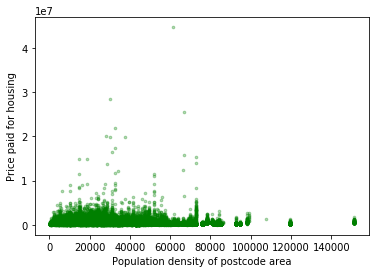

In [165]:
## create a scatter plot to show possible correlations between population density and price
home_type = 'Detached'

z = df[df['property_type'] == home_type]

plt.scatter(z.population_density_x, z.price, s=7, alpha=0.3, c='green')
plt.xlabel('Population density of postcode area')
plt.ylabel('Price paid for housing')
plt.show()

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [19]:
## Create a new dataframe with only data from the top 10 cities by sales counts

top_ten = cities_top10['town_city']

df_ten = df[df.town_city.isin(top_ten)]
        
df_ten = df_ten.reindex()

df_ten.head()

,price,transfer_date,postcode,property_type,new_build,duration,PAON,street,locality,town_city,district,county,month,year
4,184995,2018-06-15,M46 0TW,S,Y,F,37,THREADNEEDLE PLACE,ATHERTON,MANCHESTER,WIGAN,GREATER MANCHESTER,6,2018
5,214995,2018-09-28,M28 3XS,D,Y,L,9,MARPLE GARDENS,WORSLEY,MANCHESTER,SALFORD,GREATER MANCHESTER,9,2018
6,378000,2018-09-21,M45 7QN,D,N,L,36,HILLINGDON ROAD,WHITEFIELD,MANCHESTER,MANCHESTER,GREATER MANCHESTER,9,2018
10,183000,2018-08-29,M34 2WZ,S,N,L,28,HULME ROAD,DENTON,MANCHESTER,TAMESIDE,GREATER MANCHESTER,8,2018
11,111000,2018-09-28,M18 8RA,S,N,L,16,AYSGARTH AVENUE,NaN,MANCHESTER,MANCHESTER,GREATER MANCHESTER,9,2018


In [10]:
test_df = df_ten[['property_type', 'new_build', 'town_city']]
test_df.head()

,property_type,new_build,town_city
4,S,Y,MANCHESTER
5,D,Y,MANCHESTER
6,D,N,MANCHESTER
10,S,N,MANCHESTER
11,S,N,MANCHESTER


In [11]:
enc = OneHotEncoder(sparse=False)

x_encoded = enc.fit_transform(test_df)

x_encoded = pd.DataFrame(x_encoded)

x_encoded

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183738,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183739,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183740,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
183741,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
build_type = df_ten['new_build']
prop_type = df_ten['property_type']
cityID = df_ten['town_city']

xencode = LabelEncoder()
build_type = xencode.fit_transform(build_type)
xkeys = xencode.classes_
xkeys = list(xkeys)

yencode = LabelEncoder()
prop_type = yencode.fit_transform(prop_type)
ykeys = yencode.classes_
ykeys = list(ykeys)

zencode = LabelEncoder()
cityID = zencode.fit_transform(cityID)
zkeys = zencode.classes_
zkeys = list(zkeys)

cols = xkeys + ykeys + zkeys
cols

['N',
 'Y',
 'D',
 'F',
 'O',
 'S',
 'T',
 'BIRMINGHAM',
 'BRISTOL',
 'LEEDS',
 'LEICESTER',
 'LIVERPOOL',
 'LONDON',
 'MANCHESTER',
 'NOTTINGHAM',
 'SHEFFIELD',
 'SOUTHAMPTON']

In [13]:
build_type = pd.DataFrame(build_type)
prop_type = pd.DataFrame(prop_type)
cityID = pd.DataFrame(cityID)

data = pd.concat([build_type, prop_type, cityID], axis=1)
data

,0,0,0
0,1,3,6
1,1,0,6
2,0,0,6
3,0,3,6
4,0,3,6
...,...,...,...
183738,0,4,6
183739,0,1,6
183740,0,1,6
183741,0,3,6


In [14]:
data_ohe = OneHotEncoder().fit_transform(data).toarray()
z = pd.DataFrame(data_ohe)

z.columns = cols
z['price'] = df_ten.price.reset_index().price
z.head()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,N,Y,D,F,O,S,T,BIRMINGHAM,BRISTOL,LEEDS,LEICESTER,LIVERPOOL,LONDON,MANCHESTER,NOTTINGHAM,SHEFFIELD,SOUTHAMPTON,price
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,184995
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,214995
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,378000
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,183000
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,111000


### Assign the data to the scikit-learn packages, starting with Decision Trees

In [18]:
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

import locale

locale.setlocale(locale.LC_ALL, "")

feature_cols = cols

X = z[feature_cols] #features
y = z.price #target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Create Decision Tree classifer object
reg = DecisionTreeRegressor()

# Train Decision Tree Classifer
model = reg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [23]:
y_train_pred = model.predict(X_train)

np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

3795216.7466940037

In [21]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

2595266.079894468

In [ ]:
rand = np.random.uniform(low=0, high=len(df_ten))

X_new = df_ten.iloc[int(rand)]

# Model Accuracy, how often is the regressor correct?
print("City X: %s" % X_new.loc['town_city'])
print('X: £{:,.2f}, Predicted: £{:,.2f}'.format(X_new[0], y_pred[X_new[0]]))
print('Difference (£): {:+,.0f}'.format(X_new[0] - y_pred[0]))
print('Difference Predicted (%): {:+.2f}%'.format(((y_pred[0] - X_new[0]) / X_new[0]) * 100))

No handles with labels found to put in legend.


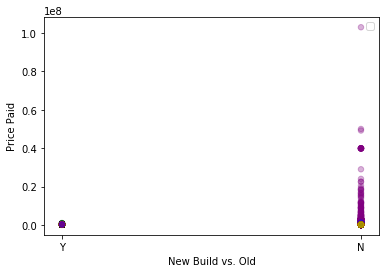

In [16]:
# City for graph
city = 'Manchester'

# number representing size
x1 = df[df['town_city'] == city.upper()].new_build

# generate array of property types
x2 = df[df['town_city'] == city.upper()].property_type

# number representing price
y = df[df['town_city'] == city.upper()].price

# create mapping from property type to matplot colour
property_type_colour_map = {'D' : 'blue', 
                            'S' : 'red', 
                            'T' : 'yellow', 
                            'F' : 'green', 
                            'O' : 'purple'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, alpha=0.3, s=30)
plt.xticks()
plt.yticks()
plt.xlabel('New Build vs. Old')
plt.ylabel('Price Paid')
plt.legend()
plt.show()

### ROUGH CELLS

### Also, we need to generalize the postcodes by removing the last 3 letters to provide a better geographical grouping (6-7 character postcodes are overly specific)

In [9]:
## Create new columns to enumerate the string data in Property Type and New Build columns
#prep_prop_type = {'D' : 1, 
#                  'S' : 2, 
#                  'T' : 3, 
#                  'F' : 4, 
#                  'O' : 5}

#prep_new_build = {'N': 0, 
#                  'Y': 1}

#df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
#df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]